# CPSC 330 Lecture 16

### Lecture plan

- Announcements
- Time series data
- Parsing datetimes (5 min)
- Train/test splits with temporal data (10 min)
- Encoding date/time as feature(s) (15 min)
- Break (5 min)
- Lag-based features (15 min)
- What did we not cover? (10 min)
- T/F questions (15 min)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
from datetime import datetime

# TODO

- Introduce [Prophet](https://facebook.github.io/prophet/docs/quick_start.html) here as well? It seems to know about things like holidays and such - good for forecasting involving humans.
  - Note: this depends on Stan/pystan, maybe be a hassle to install depending on the OS.
- sklearn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html); see also [here](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)
- Would it be better to predict the _change_ in rain (or other value) rather than predict the new one itself given the old one? If you predict the change, would you still keep the old one as a feature? Sure, why not? But you might add the lags of the changes?
- Should we not be scaling the lagged version of the target?
- Maybe need a different dataset for this (swap lecture & hw datasets?), but we should really cover the idea of _trends_. An, it's important to teach the students how `Ridge` and `RandomForestRegressor`, and maybe other models, behave w.r.t. extrapolating trends into the future. They behave very differently and the students currently aren't equipped to understand this / avoid doing this incorrectly.
- Add in the part on forecasting multiple time steps into the future by using the prediction as the feature value. I started working on this but ran out of time. Seems useful.
- Look through [Tom's Capstone seminar](https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb). There is some good code in there, e.g. `lag_df` uses `df.shift`, which seems a lot more elegant than what I've done. This applies to the avocado homework as well. He also has the predicting further in the future with a `for` loop, as well was ts cross validation. `month_name()` function looks useful too!

## Announcements

- Final exam date: April 24 at 12:00 in OSBO A.
- hw6 posted, due Sunday at 6pm.

## Time series data

We have actually seen timestamps in our datasets before, but we have just ignored them until now.

[Trump Tweets](https://www.kaggle.com/austinreese/trump-tweets) dataset from hw6:

In [4]:
df_trump = pd.read_csv("data/trumptweets.csv")
df_trump.head()

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN


[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset from the midterm:

In [5]:
df_rain = pd.read_csv("data/weatherAUS.csv")
df_rain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


#### Goals

- Can the date/time features help us predict the target value?
- Can we **forecast** into the future?

## Parsing datetimes (5 min)

- In general, datetimes are a huge pain! Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
- No, seriously, dealing with datetimes is THE WORST.
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [6]:
dates_trump = pd.to_datetime(df_trump["date"])
dates_trump

0       2009-05-04 20:54:25
1       2009-05-05 03:00:10
2       2009-05-08 15:38:08
3       2009-05-08 22:40:15
4       2009-05-12 16:07:28
                ...        
41117   2020-01-19 19:24:52
41118   2020-01-19 22:12:20
41119   2020-01-20 01:27:07
41120   2020-01-20 02:16:00
41121   2020-01-20 02:57:49
Name: date, Length: 41122, dtype: datetime64[ns]

See [here](https://docs.python.org/3.8/library/datetime.html) for the Python `datetime` documentation.

You can subtract dates:

In [7]:
dates_trump[1] - dates_trump[0]

Timedelta('0 days 06:05:45')

These differences are signed:

In [8]:
dates_trump[0] - dates_trump[1]

Timedelta('-1 days +17:54:15')

We can get the number of seconds:

In [9]:
(dates_trump[1] - dates_trump[0]).total_seconds()

21945.0

In [10]:
(dates_trump[0] - dates_trump[1]).total_seconds()

-21945.0

We can do the same for the rain dataset:

In [11]:
dates_rain = pd.to_datetime(df_rain["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
142188   2017-06-20
142189   2017-06-21
142190   2017-06-22
142191   2017-06-23
142192   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

In [12]:
dates_rain[1] - dates_rain[0]

Timedelta('1 days 00:00:00')

They are all the same format, so we can also compare dates from the two datasets:

In [13]:
dates_rain[1] - dates_trump[1]

Timedelta('-155 days +20:59:50')

In [14]:
dates_rain[1] > dates_trump[1]

False

You can tell pandas to parse the dates when reading in the CSV:

In [15]:
df_rain = pd.read_csv("data/weatherAUS.csv", parse_dates=["Date"])
df_rain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [16]:
df_rain["Date"].head()

0   2008-12-01
1   2008-12-02
2   2008-12-03
3   2008-12-04
4   2008-12-05
Name: Date, dtype: datetime64[ns]

- For the rest of today, we'll focus on the rain in Australia dataset.

## Train/test splits with temporal data (10 min)

Let's do the usual thing we do...

In [27]:
def preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features):

    all_features = set(numeric_features + categorical_features + drop_features)
    if set(df_train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])  
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),#'constant', fill_value='?')),
        ('onehot', OneHotEncoder(sparse=False, drop='first'))#handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])
    preprocessor.fit(df_train);

    ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names(categorical_features))
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(preprocessor.transform(df_train), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(df_test),  index=df_test.index,  columns=new_columns)
    
    y_train = df_train["RainTomorrow"]
    y_test  = df_test["RainTomorrow"]
    
    return X_train_enc, y_train, X_test_enc, y_test

In [28]:
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                    'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
drop_features = ['RISK_MM', 'Date', 'RainTomorrow']  # See the documentation, should not keep the column

In [29]:
df_train, df_test = train_test_split(df_rain)

In [30]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features, categorical_features, drop_features)

Now we do the modelling:

In [22]:
lr = LogisticRegression(max_iter=1000)

In [23]:
lr.fit(X_train_enc, y_train);

In [24]:
lr.score(X_train_enc, y_train)

0.8473144293162297

In [25]:
lr.score(X_test_enc, y_test)

0.8500098455652761

- But, wait a minute, I did something horribly wrong. Any ideas?

<br><br><br><br><br><br>

- Let's look at the dates in our train/test split:

In [26]:
df_train["Date"].max()

Timestamp('2017-06-25 00:00:00')

In [27]:
df_test["Date"].min()

Timestamp('2007-11-11 00:00:00')

- So, we are training on data that came before our test data!
- If we want to forecast, we aren't allowed to know what happened in the future!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

In [ ]:
# test_pred = df_test.sort_values(by=["Location", "Date"])
# np.mean(test_pred["RainToday"].iloc[1:].values == test_pred["RainTomorrow"].iloc[-1:].values)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


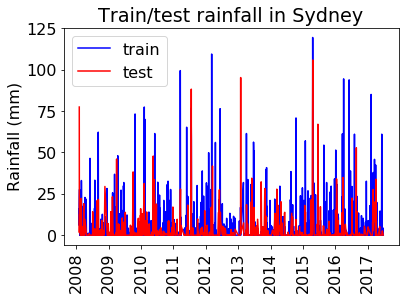

In [28]:
df_train_sort = df_train.query("Location == 'Sydney'").sort_values(by="Date")
df_test_sort = df_test.query("Location == 'Sydney'").sort_values(by="Date")

plt.plot(df_train_sort["Date"], df_train_sort["Rainfall"], 'b', label='train');
plt.plot(df_test_sort["Date"], df_test_sort["Rainfall"], 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();
plt.ylabel("Rainfall (mm)");
plt.title("Train/test rainfall in Sydney");

In [29]:
df_rain["Date"].min()

Timestamp('2007-11-01 00:00:00')

In [30]:
df_rain["Date"].max()

Timestamp('2017-06-25 00:00:00')

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.
- For time series data, I recommend splitting into 2 sets, as the train/validation/test situation can get more confusing.
  - If things are going well, your validation error and your test error should be about the same.
  - That would not be the case with temporal data, because you'd be forecasting farther into the future with your test set.

In [31]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [32]:
len(df_train)

107502

In [33]:
len(df_test)

34691

In [34]:
len(df_test)/(len(df_train)+len(df_test))

0.24397122221206388

As we can see, we're still using about 25% of our data as test data.

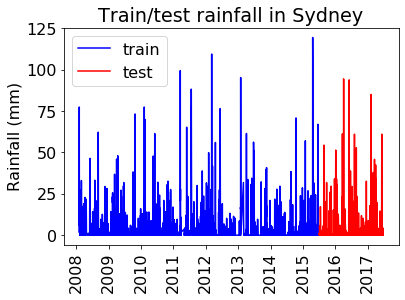

In [35]:
df_train_sort = df_train.query("Location == 'Sydney'").sort_values(by="Date")
df_test_sort = df_test.query("Location == 'Sydney'").sort_values(by="Date")

plt.plot(df_train_sort["Date"], df_train_sort["Rainfall"], 'b', label='train');
plt.plot(df_test_sort["Date"], df_test_sort["Rainfall"], 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();
plt.ylabel("Rainfall (mm)");
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

In [37]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features, categorical_features, drop_features)

In [38]:
lr.fit(X_train_enc, y_train);

In [39]:
lr.score(X_train_enc, y_train)

0.8493051292068985

In [40]:
lr.score(X_test_enc, y_test)

0.8443112046352079

In [41]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.235705
Pressure9am,0.869941
WindGustSpeed,0.714413
WindDir3pm_NNW,0.511805
WindDir9am_NNE,0.463215
...,...
Pressure3pm,-1.227455
Location_Katherine,-1.251053
Location_Townsville,-1.286921
Location_Wollongong,-1.301621


In [42]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train_enc, y_train);

In [43]:
dc.score(X_train_enc, y_train)

0.7750553478074826

In [44]:
dc.score(X_test_enc, y_test)

0.7781845435415525

#### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- We can change the threshold for the train/test split.
- Sometimes always predict 1 (or $m$) steps ahead of the training set.
- We won't go into this here.

Actually, our training split is a bit weird because we "have the answers" in the training set. But our testing procedure is conservative.

Q: Why can't we do regular cross validation with time series?

A: Cross-validation randomly shuffles the rows, so you might get rows in your training set that occur after rows in your validation set. This isn't 100% terrible in that you're still predicting next week's price regardless, but it's not a good idea. Especially if there are trends in the dataset, and then you get to see what happened to the trend in the future.

Also there is:

In [1]:
from sklearn.model_selection import TimeSeriesSplit

see https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split

## Encoding date/time as feature(s) (15 min)

- Can we use the `Date` to help us?

#### Encoding time as an number

- Idea 1: create a column of "days since Nov 1, 2007".

In [45]:
first_day = df_train["Date"].min()
df_train["Days Since"] = df_train["Date"].apply(lambda x: (x-first_day).days)
df_test["Days Since"] = df_test["Date"].apply(lambda x: (x-first_day).days)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
df_train.sort_values(by='Date').head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Days Since
44351,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,1019.7,1015.0,7.0,7.0,14.4,23.6,No,3.6,Yes,0
44352,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,3.6,Yes,1
44353,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,39.8,Yes,2
44354,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,2.8,Yes,3
44355,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,0.0,No,4


In [47]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features  + ["Days Since"], 
        categorical_features, 
        drop_features)

In [48]:
lr.fit(X_train_enc, y_train);

In [49]:
lr.score(X_train_enc, y_train)

0.8492865249018623

In [50]:
lr.score(X_test_enc, y_test)

0.844426508316278

- Can you think of other ways to generate features from the `Date` columns? 
- What about the month - that seems relevant. How should we encode the month? Discuss.

<br><br><br><br><br><br>

Another idea month: encode as integer, categorical variable?

#### One-hot encoding of the month

In [170]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [171]:
df_train["Month"] = df_train["Date"].apply(lambda x: x.month)
df_test["Month"] = df_test["Date"].apply(lambda x: x.month)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [172]:
df_train[["Date", "Month"]].sort_values(by="Month")

,Date,Month
31930,2015-01-04,1
37595,2014-01-20,1
37594,2014-01-19,1
37593,2014-01-18,1
37592,2014-01-17,1
...,...,...
46478,2013-12-05,12
46477,2013-12-04,12
46476,2013-12-03,12
46474,2013-12-01,12


In [173]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features, 
        categorical_features + ["Month"], 
        drop_features)

In [174]:
lr.fit(X_train_enc, y_train);

In [175]:
lr.score(X_train_enc, y_train)

0.8498725605105021

In [176]:
lr.score(X_test_enc, y_test)

0.8436482084690554

In [177]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.259227
Pressure9am,0.802580
WindGustSpeed,0.699259
Month_8,0.651450
Month_7,0.591337
...,...
Location_MountGinini,-1.227450
Location_Wollongong,-1.316730
Location_Darwin,-1.318083
Location_Katherine,-1.470019


In [178]:
lr_coef.loc["Month_2":"Month_12"]

,Coef
Month_2,0.258324
Month_3,0.294427
Month_4,0.497965
Month_5,0.562242
Month_6,0.474007
Month_7,0.591337
Month_8,0.651450
Month_9,0.452801
Month_10,0.535758
Month_11,0.455749


#### One-hot encoding seasons

How about just summer/winter as a feature?

In [179]:
df_train["Winter"] = df_train["Month"].isin({5,6,7,8,9})
df_test["Winter"] = df_test["Month"].isin({5,6,7,8,9})

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [180]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features + ["Winter"], 
        categorical_features, 
        drop_features + ["Month"])

In [181]:
lr.fit(X_train_enc, y_train);

In [182]:
lr.score(X_train_enc, y_train)

0.8491748990716452

In [183]:
lr.score(X_test_enc, y_test)

0.8442247268744054

In [184]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.238646
Pressure9am,0.857543
WindGustSpeed,0.710636
WindDir3pm_NNW,0.505878
RainToday_Yes,0.457261
...,...
Pressure3pm,-1.217295
Location_Katherine,-1.294799
Location_Wollongong,-1.301623
Location_Townsville,-1.331094


In [185]:
lr_coef.loc["Winter"]

Coef    0.039282
Name: Winter, dtype: float64

- It's a bit surprising that these features don't help much.


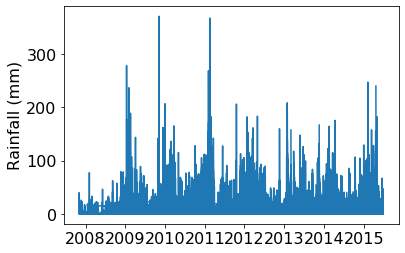

In [186]:
plt.plot(df_train["Date"], df_train["Rainfall"]);
plt.ylabel("Rainfall (mm)");

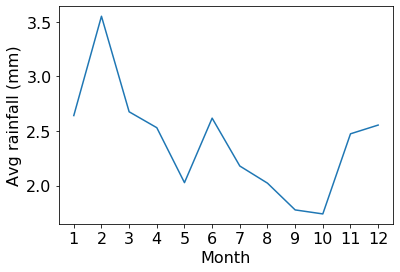

In [187]:
monthly_avg_rainfall = df_train.groupby("Month")["Rainfall"].mean()
plt.plot(monthly_avg_rainfall);
plt.xticks(np.arange(1,13).astype(int));
plt.ylabel("Avg rainfall (mm)");
plt.xlabel("Month");

In [188]:
df_train.sort_values(by="Date", ascending=False)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month,Winter
141478,2015-06-30,Uluru,6.8,21.1,0.0,NaN,NaN,ESE,35.0,ESE,...,1025.2,3.0,NaN,10.6,20.2,No,0.0,No,6,True
138387,2015-06-30,Darwin,18.3,32.6,0.0,6.0,11.0,ESE,37.0,E,...,1013.3,1.0,1.0,24.0,31.6,No,0.0,No,6,True
96224,2015-06-30,Adelaide,7.2,13.8,0.0,NaN,NaN,SW,17.0,ENE,...,1029.5,NaN,NaN,10.1,12.7,No,0.0,No,6,True
55977,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,1027.7,NaN,8.0,4.7,9.3,No,0.4,No,6,True
93135,2015-06-30,Townsville,20.0,27.4,0.4,6.6,4.6,SE,46.0,SE,...,1019.2,7.0,6.0,23.5,26.2,No,0.0,No,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44355,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,1018.5,7.0,7.0,11.1,15.4,Yes,0.0,No,11,False
44354,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,1007.0,2.0,7.0,13.5,14.1,Yes,2.8,Yes,11,False
44353,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,1007.2,8.0,7.0,15.4,20.2,Yes,39.8,Yes,11,False
44352,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,1008.4,5.0,3.0,17.5,25.7,Yes,3.6,Yes,11,False


- This pattern is pretty surprising to me - why is June rainy but May and August are less so?
- But, Australia is a huge country. Perhaps we should drill down to particular locations:

In [189]:
df_train_canberra  = df_train.query('Location == "Canberra"')

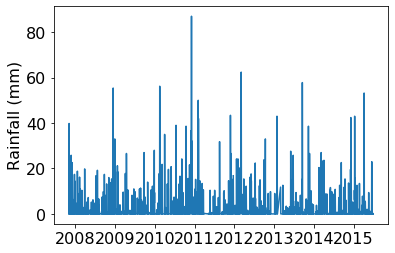

In [190]:
plt.plot(df_train_canberra["Date"], df_train_canberra["Rainfall"]);
plt.ylabel("Rainfall (mm)");

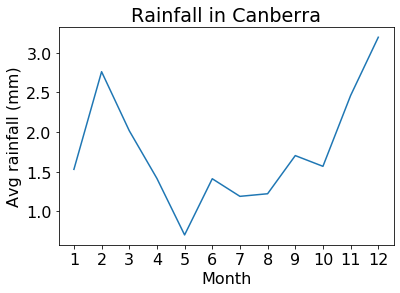

In [195]:
plt.plot(df_train_canberra.groupby("Month")["Rainfall"].mean());
plt.xticks(np.arange(1,13).astype(int));
plt.ylabel("Avg rainfall (mm)");
plt.xlabel("Month");
plt.title("Rainfall in Canberra");

- This looks somewhat cleaner but also pretty surprising - why is December so much higher than January?
- This is called _seasonality_.
- Why was the month feature not that useful? Perhaps this was already captured in the other features.
  - But also the encoding wasn't ideal.

#### Periodic encoding

- We can also try a periodic encoding.
- This works because we know the periodicity (annual).
- We can use a sin and cos with period 1 year.
- You can shift the period by adding together $\sin(x)$ and $\cos(x)$:

In [196]:
df_train["Month_sin"] = np.sin(2*np.pi*df_train["Month"]/12)
df_train["Month_cos"] = np.cos(2*np.pi*df_train["Month"]/12)

df_test["Month_sin"] = np.sin(2*np.pi*df_test["Month"]/12)
df_test["Month_cos"] = np.cos(2*np.pi*df_test["Month"]/12)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

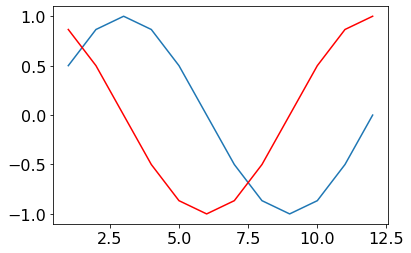

In [197]:
month = np.arange(1,13)
enc_sin = np.sin(2*np.pi*month/12)
enc_cos = np.cos(2*np.pi*month/12)
plt.plot(month,enc_sin);
plt.plot(month,enc_cos, 'r');

In [198]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features + ["Month_sin", "Month_cos"], 
        categorical_features, 
        drop_features + ["Month", "Winter"])

In [199]:
lr.fit(X_train_enc, y_train);

In [200]:
lr.score(X_train_enc, y_train)

0.8493981507320794

In [201]:
lr.score(X_test_enc, y_test)

0.8438499899109279

In [203]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc[["Month_sin", "Month_cos"]]

,Coef
Month_sin,-0.093847
Month_cos,-0.127489


**From Piazza last year**

Q: How to interpret coefficients for periodic encoded features?

A: They are both negative, so it means the price is higher when sin(2 pi month / 12) is lower and when cos(2 pi month / 12) is lower. In fact, since this is a linear model, we can just combine them: it means the price is higher when -0.016 sin(2 pi month / 12) - 0.013 cos(2 pi month / 12) is high. You can plot this function. I plotted it - see attached image. It shows that the predicted price is higher roughly from months 5-11, meaning May-November, with the lowest price falling around Jan-Feb and the highest price around August.

Optional note: by following trigonometric identities, we can see that learning  $A\sin(x)+B\cos(x)$  is the same as learning  $C\sin(x-\phi)$, or in other words a phase-shifted sine wave. 

However, all this only applies because it's a linear model. For something like a random forest, these coefficients would be harder to interpret.


#### Encoding average monthly rainfall 

We can also try encoding the average rainfall for that month a a feature:

In [204]:
monthly_avg_rainfall

Month
1     2.641089
2     3.550847
3     2.675817
4     2.530029
5     2.026871
6     2.617369
7     2.179104
8     2.022084
9     1.777074
10    1.740375
11    2.474031
12    2.554032
Name: Rainfall, dtype: float64

In [205]:
df_train["Monthly rainfall"] = df_train["Date"].apply(lambda x: monthly_avg_rainfall[x.month])
df_test["Monthly rainfall"] = df_test["Date"].apply(lambda x: monthly_avg_rainfall[x.month])

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [206]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features + ["Monthly rainfall"], 
        categorical_features, 
        drop_features + ["Month", "Winter", "Month_sin", "Month_cos"])

In [207]:
lr.fit(X_train_enc, y_train);

In [208]:
lr.score(X_train_enc, y_train)

0.8495190787148146

In [209]:
lr.score(X_test_enc, y_test)

0.8443400305554755

In [210]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc["Monthly rainfall"]

Coef   -0.057631
Name: Monthly rainfall, dtype: float64

Hmm, it's a bit worrying that this coefficient is negative...

#### Average monthly rainfall by location

In [211]:
avg_monthly_rainfall_by_loc = df_train.groupby(["Month", "Location"])["Rainfall"].mean()

In [212]:
df_train["Monthly rainfall at loc"] = df_train.groupby(["Month", "Location"])["Rainfall"].transform('mean')
df_test["Monthly rainfall at loc"] = df_test.groupby(["Month", "Location"])["Rainfall"].transform('mean')

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [215]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features + ["Monthly rainfall at loc"], 
        categorical_features, 
        drop_features + ["Month", "Winter", "Month_sin", "Month_cos", "Monthly rainfall"])

In [216]:
lr.fit(X_train_enc, y_train);

In [217]:
lr.score(X_train_enc, y_train)

0.8502167401536715

In [218]:
lr.score(X_test_enc, y_test)

0.8443976823960105

In [219]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc["Monthly rainfall at loc"]

Coef    0.217977
Name: Monthly rainfall at loc, dtype: float64

## Break (5 min)

## Lag-based features (15 min)

- Currently we're using features about today to predict tomorrow's rainfall.
- But, what if tomorrow's rainfall is also related to yesterday's features, or the day before?
  - This is called a _lagged_ feature.
- In time series analysis, we'd look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here.
- Instead, we can just add those features:

In [77]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [78]:
df_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141474,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,37.0,1031.5,1027.6,NaN,NaN,8.8,17.2,No,0.0,No
141475,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,40.0,1029.9,1026.0,NaN,NaN,7.0,15.7,No,0.0,No
141476,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,39.0,1028.7,1025.0,NaN,3.0,8.9,18.0,No,0.0,No
141477,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,37.0,1027.2,1023.8,6.0,7.0,11.7,21.5,No,0.0,No


- It looks like the dataframe is already sorted by Location and then by date for each Location.
- We could have done this ourselves with

In [ ]:
# df_train.sort_values(by=["Location", "Date"])

But make sure to also sort the targets (i.e. do this before preprocessing).

In [79]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    
    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby("Location"):
        new_df.loc[df_location.index[lag:],new_feature_name] = df_location.iloc[:-lag][orig_feature].values
    return new_df

In [80]:
df_train = create_lag_feature(df_train, "Rainfall", 1)

In [81]:
df_train[["Date", "Location", "Rainfall", "Rainfall_lag1"]].head(20)

,Date,Location,Rainfall,Rainfall_lag1
0,2008-12-01,Albury,0.6,NaN
1,2008-12-02,Albury,0.0,0.6
2,2008-12-03,Albury,0.0,0.0
3,2008-12-04,Albury,0.0,0.0
4,2008-12-05,Albury,1.0,0.0
5,2008-12-06,Albury,0.2,1.0
6,2008-12-07,Albury,0.0,0.2
7,2008-12-08,Albury,0.0,0.0
8,2008-12-09,Albury,0.0,0.0
9,2008-12-10,Albury,1.4,0.0


In [82]:
df_train[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2285:2295]

,Date,Location,Rainfall,Rainfall_lag1
2285,2015-06-26,Albury,0.2,1.0
2286,2015-06-27,Albury,0.0,0.2
2287,2015-06-28,Albury,0.2,0.0
2288,2015-06-29,Albury,0.0,0.2
2289,2015-06-30,Albury,0.0,0.0
3011,2009-01-01,BadgerysCreek,0.0,NaN
3012,2009-01-02,BadgerysCreek,0.0,0.0
3013,2009-01-03,BadgerysCreek,0.0,0.0
3014,2009-01-04,BadgerysCreek,0.0,0.0
3015,2009-01-05,BadgerysCreek,0.0,0.0


- Looks good.

- Question: is it OK to do this to the test set? Discuss.

<br><br><br><br><br><br>

- It's fine if you would have this information available in deployment.
- If we're just forecasting the next day, we should.
- Let's include it for now.

Another question: is there a difference between doing this and then splitting, vs. splitting and then doing this?

<br><br><br><br><br><br>

- Answer: a tiny difference: the first day of the test set, for each location, will have a `NaN`. 
  - That might actually be too strict.
  - It should be fine to do this before splitting.

In [83]:
df_rain_modified = create_lag_feature(df_rain, "Rainfall", 1)

In [84]:
df_train = df_rain_modified.query('Date <= 20150630')
df_test  = df_rain_modified.query('Date >  20150630')

In [85]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features + ["Rainfall_lag1"], 
        categorical_features, 
        drop_features)

In [86]:
lr.fit(X_train_enc, y_train);

In [87]:
lr.score(X_train_enc, y_train)

0.8493702442745251

In [88]:
lr.score(X_test_enc, y_test)

0.8444553342365455

In [89]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.234774
Pressure9am,0.870648
WindGustSpeed,0.714507
WindDir3pm_NNW,0.514199
WindDir9am_NNE,0.465163
...,...
Pressure3pm,-1.227812
Location_Katherine,-1.247338
Location_Townsville,-1.287123
Location_Wollongong,-1.298879


In [90]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

,Coef
Rainfall,0.080649
Rainfall_lag1,0.009780


- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also created lagged version of other features, or more lags

In [91]:
df_rain_modified = create_lag_feature(df_rain, "Rainfall", 1)
df_rain_modified = create_lag_feature(df_rain_modified, "Rainfall", 2)
df_rain_modified = create_lag_feature(df_rain_modified, "Rainfall", 3)
df_rain_modified = create_lag_feature(df_rain_modified, "Humidity3pm", 1)

In [92]:
df_rain_modified[['Date', 'Location', 'Rainfall', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm', 'Humidity3pm_lag1']].head(10)

,Date,Location,Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Humidity3pm,Humidity3pm_lag1
0,2008-12-01,Albury,0.6,NaN,NaN,NaN,22.0,NaN
1,2008-12-02,Albury,0.0,0.6,NaN,NaN,25.0,22.0
2,2008-12-03,Albury,0.0,0.0,0.6,NaN,30.0,25.0
3,2008-12-04,Albury,0.0,0.0,0.0,0.6,16.0,30.0
4,2008-12-05,Albury,1.0,0.0,0.0,0.0,33.0,16.0
5,2008-12-06,Albury,0.2,1.0,0.0,0.0,23.0,33.0
6,2008-12-07,Albury,0.0,0.2,1.0,0.0,19.0,23.0
7,2008-12-08,Albury,0.0,0.0,0.2,1.0,19.0,19.0
8,2008-12-09,Albury,0.0,0.0,0.0,0.2,9.0,19.0
9,2008-12-10,Albury,1.4,0.0,0.0,0.0,27.0,9.0


Note the pattern of `NaN` values. 

In [93]:
df_train = df_rain_modified.query('Date <= 20150630')
df_test  = df_rain_modified.query('Date >  20150630')

In [94]:
X_train_enc, y_train, X_test_enc, y_test = preprocess_features(df_train, df_test, 
        numeric_features + ['Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm_lag1'], 
        categorical_features, 
        drop_features)

In [95]:
lr.fit(X_train_enc, y_train);

In [96]:
lr.score(X_train_enc, y_train)

0.8504958047292144

In [97]:
lr.score(X_test_enc, y_test)

0.8459831080107233

In [98]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.270577
Pressure9am,0.900104
WindGustSpeed,0.701418
RainToday_Yes,0.546420
WindDir3pm_NNW,0.520046
...,...
Location_Wollongong,-1.159234
Location_Townsville,-1.171667
Location_Katherine,-1.233013
Pressure3pm,-1.258980


In [99]:
lr_coef.loc[['Rainfall', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm', 'Humidity3pm_lag1']]

,Coef
Rainfall,0.107757
Rainfall_lag1,0.024056
Rainfall_lag2,0.018639
Rainfall_lag3,0.018548
Humidity3pm,1.270577
Humidity3pm_lag1,-0.265619


## What did we not cover? (10 min)

- A huge amount!

#### Traditional time series approaches

- Time series analysis is a huge field of its own (notice a pattern here?)
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We will take a different route in this course, and stick to our supervised learning tools.

#### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 540 (soon to be renamed 440).
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.
  - [Here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) is the documentation for the LSTM in tf.keras.

#### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 14), LSTMs, and non deep learning methods.
- Inference problems.
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
 - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month / looking at seasonality.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

#### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.
  - We may still have a class on feature engineering... TBD.

#### Forecasting further into the future

- What if we want to forecast 2 days into the future, or 5 days?
- We could train a model where the response was 2 days ahead. 
  - Basically, all features would be lagged. 
- What if you want to use the same model to forecast 1, 2, 3, 4, 5 days ahead?
  - You could train the model using lags 1-5. 
  - For 5 days, only lag 5 would be available.
  - For 4 days, only lags 4-5 would be available.
  - For 1 days, all would be available.
- Another approach is to ty to predict the lagged features.

## T/F questions (15 min)

1. The rain in Australia dataset contains a single time series; that is, each date has a unique row associated with it.
2. A reasonable approach to encoding the date would be one-hot encoding the days of the year (from 1-365).
3. It is better to OHE the month than to encode it as an integer (i.e. ordinal).
4. It is important to train/test split before we create our lagged features.
5. If we have a feature with lag 3 in our dataset, that feature will be missing if we try to forecast 5 days into the future.

<br><br><br><br><br><br>